In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform('gpu')

In [2]:
import arviz as az
from leaguedata.plot import plot_history, plot_compare_plotly
from leaguedata.model import generate_coinflip_history, generate_nasty_loser_q, generate_obvious_loser_q

# Obvious LoserQ

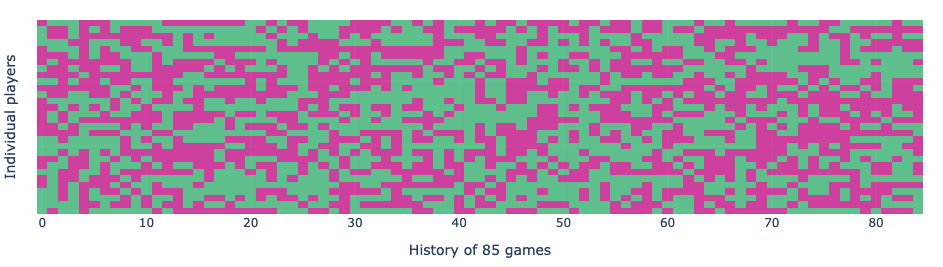

In [3]:
mock_history = generate_obvious_loser_q(number_of_players=30, number_of_games=85)
plot_history(mock_history, save_to='docs/loserQ/assets/validation_obvious.json');

In [4]:
from leaguedata.inference import fit_history_with_dmc

mock_history = generate_obvious_loser_q(number_of_players=100, number_of_games=85)
dict_of_id = fit_history_with_dmc(mock_history)
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

sample: 100%|██████████| 2000/2000 [00:11<00:00, 178.03it/s]


rank     elpd_loo      p_loo   elpd_diff        weight         se  \
4 games     0 -5746.170979  15.630770    0.000000  9.438344e-01  18.719125   
5 games     1 -5757.502550  31.854526   11.331571  0.000000e+00  18.990697   
6 games     2 -5772.193960  63.231459   26.022980  0.000000e+00  20.463385   
3 games     3 -5780.179082   8.683346   34.008103  3.184859e-02  17.275732   
2 games     4 -5809.029422   5.033145   62.858442  3.869927e-12  15.247387   
1 games     5 -5847.656095   3.027300  101.485116  2.431699e-02   9.710728   
0 games     6 -5893.410067   2.391930  147.239088  4.248824e-12   0.406371   

               dse  warning scale  
4 games   0.000000    False   log  
5 games   3.726584    False   log  
6 games   7.335118    False   log  
3 games   8.949805    False   log  
2 games  11.379976    False   log  
1 games  14.440005    False   log  
0 games  18.760360    False   log

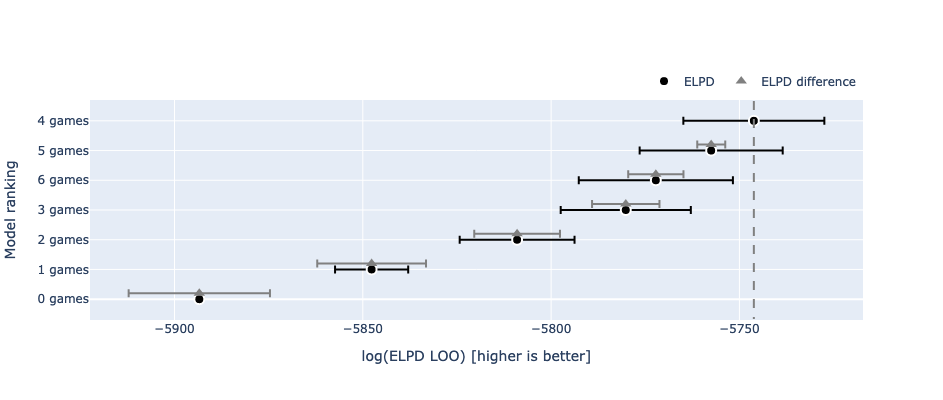

In [5]:
plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/validation_obvious_compare.json');

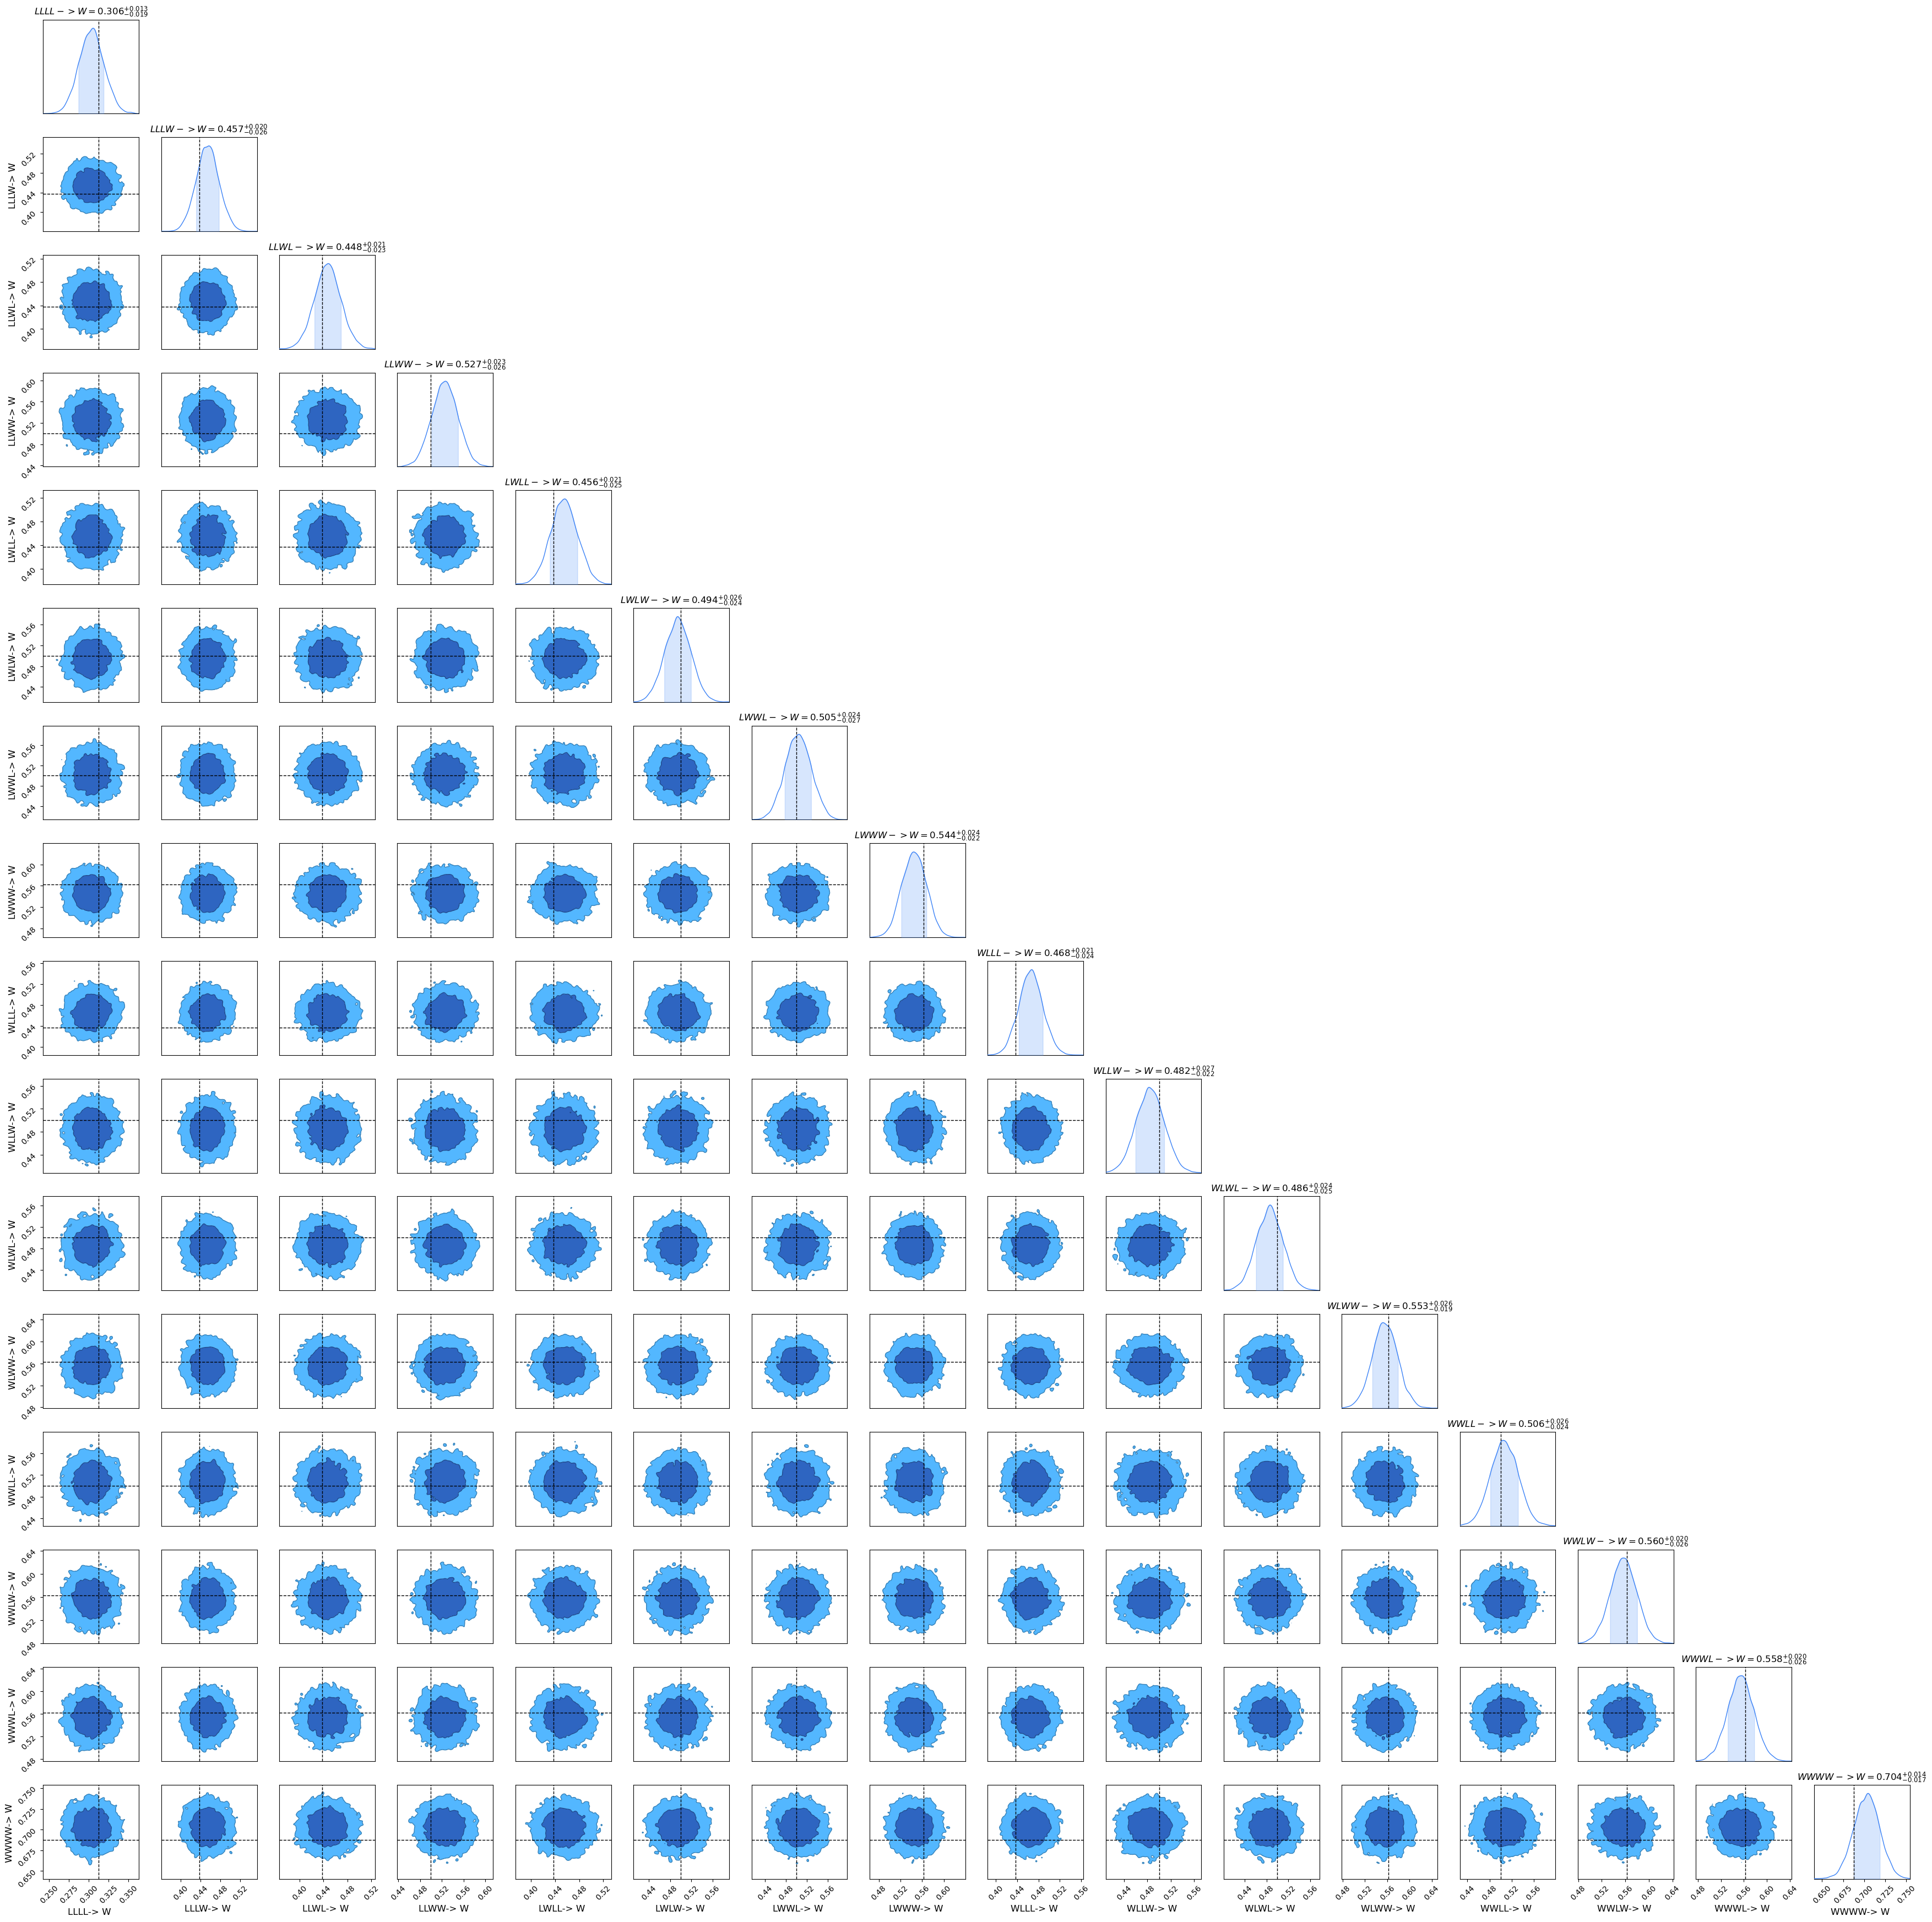

In [21]:
import numpy as np
import pandas as pd 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from leaguedata.inference import DTMCModel
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4 games']
markov_util = DTMCModel(4)
samples = np.asarray(az.extract(best_id).proba)

probs = jnp.empty((2 ** 4))
importance = 0.5

probs_keys = {
    0.: 0.5 - 0.375 * importance,
    0.25: 0.5 - 0.125 * importance,
    0.5: 0.5,
    0.75: 0.5 + 0.125 * importance,
    1.: 0.5 + 0.375 * importance
}

for i, state in enumerate(markov_util.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state) / 4])

dict_of_samples = {''.join(["W" if win else "L" for win in state]) + '-> W':samples[i] for i, state in enumerate(markov_util.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.add_truth(
    Truth(location=
          {''.join(["W" if win else "L" for win in state]) + '-> W':float(probs[i]) for i, state in enumerate(markov_util.get_states())}
    )
)

cc.plotter.plot()
plt.tight_layout()
plt.savefig('docs/loserQ/assets/obvious_loserq_whitemode.png', bbox_inches='tight');

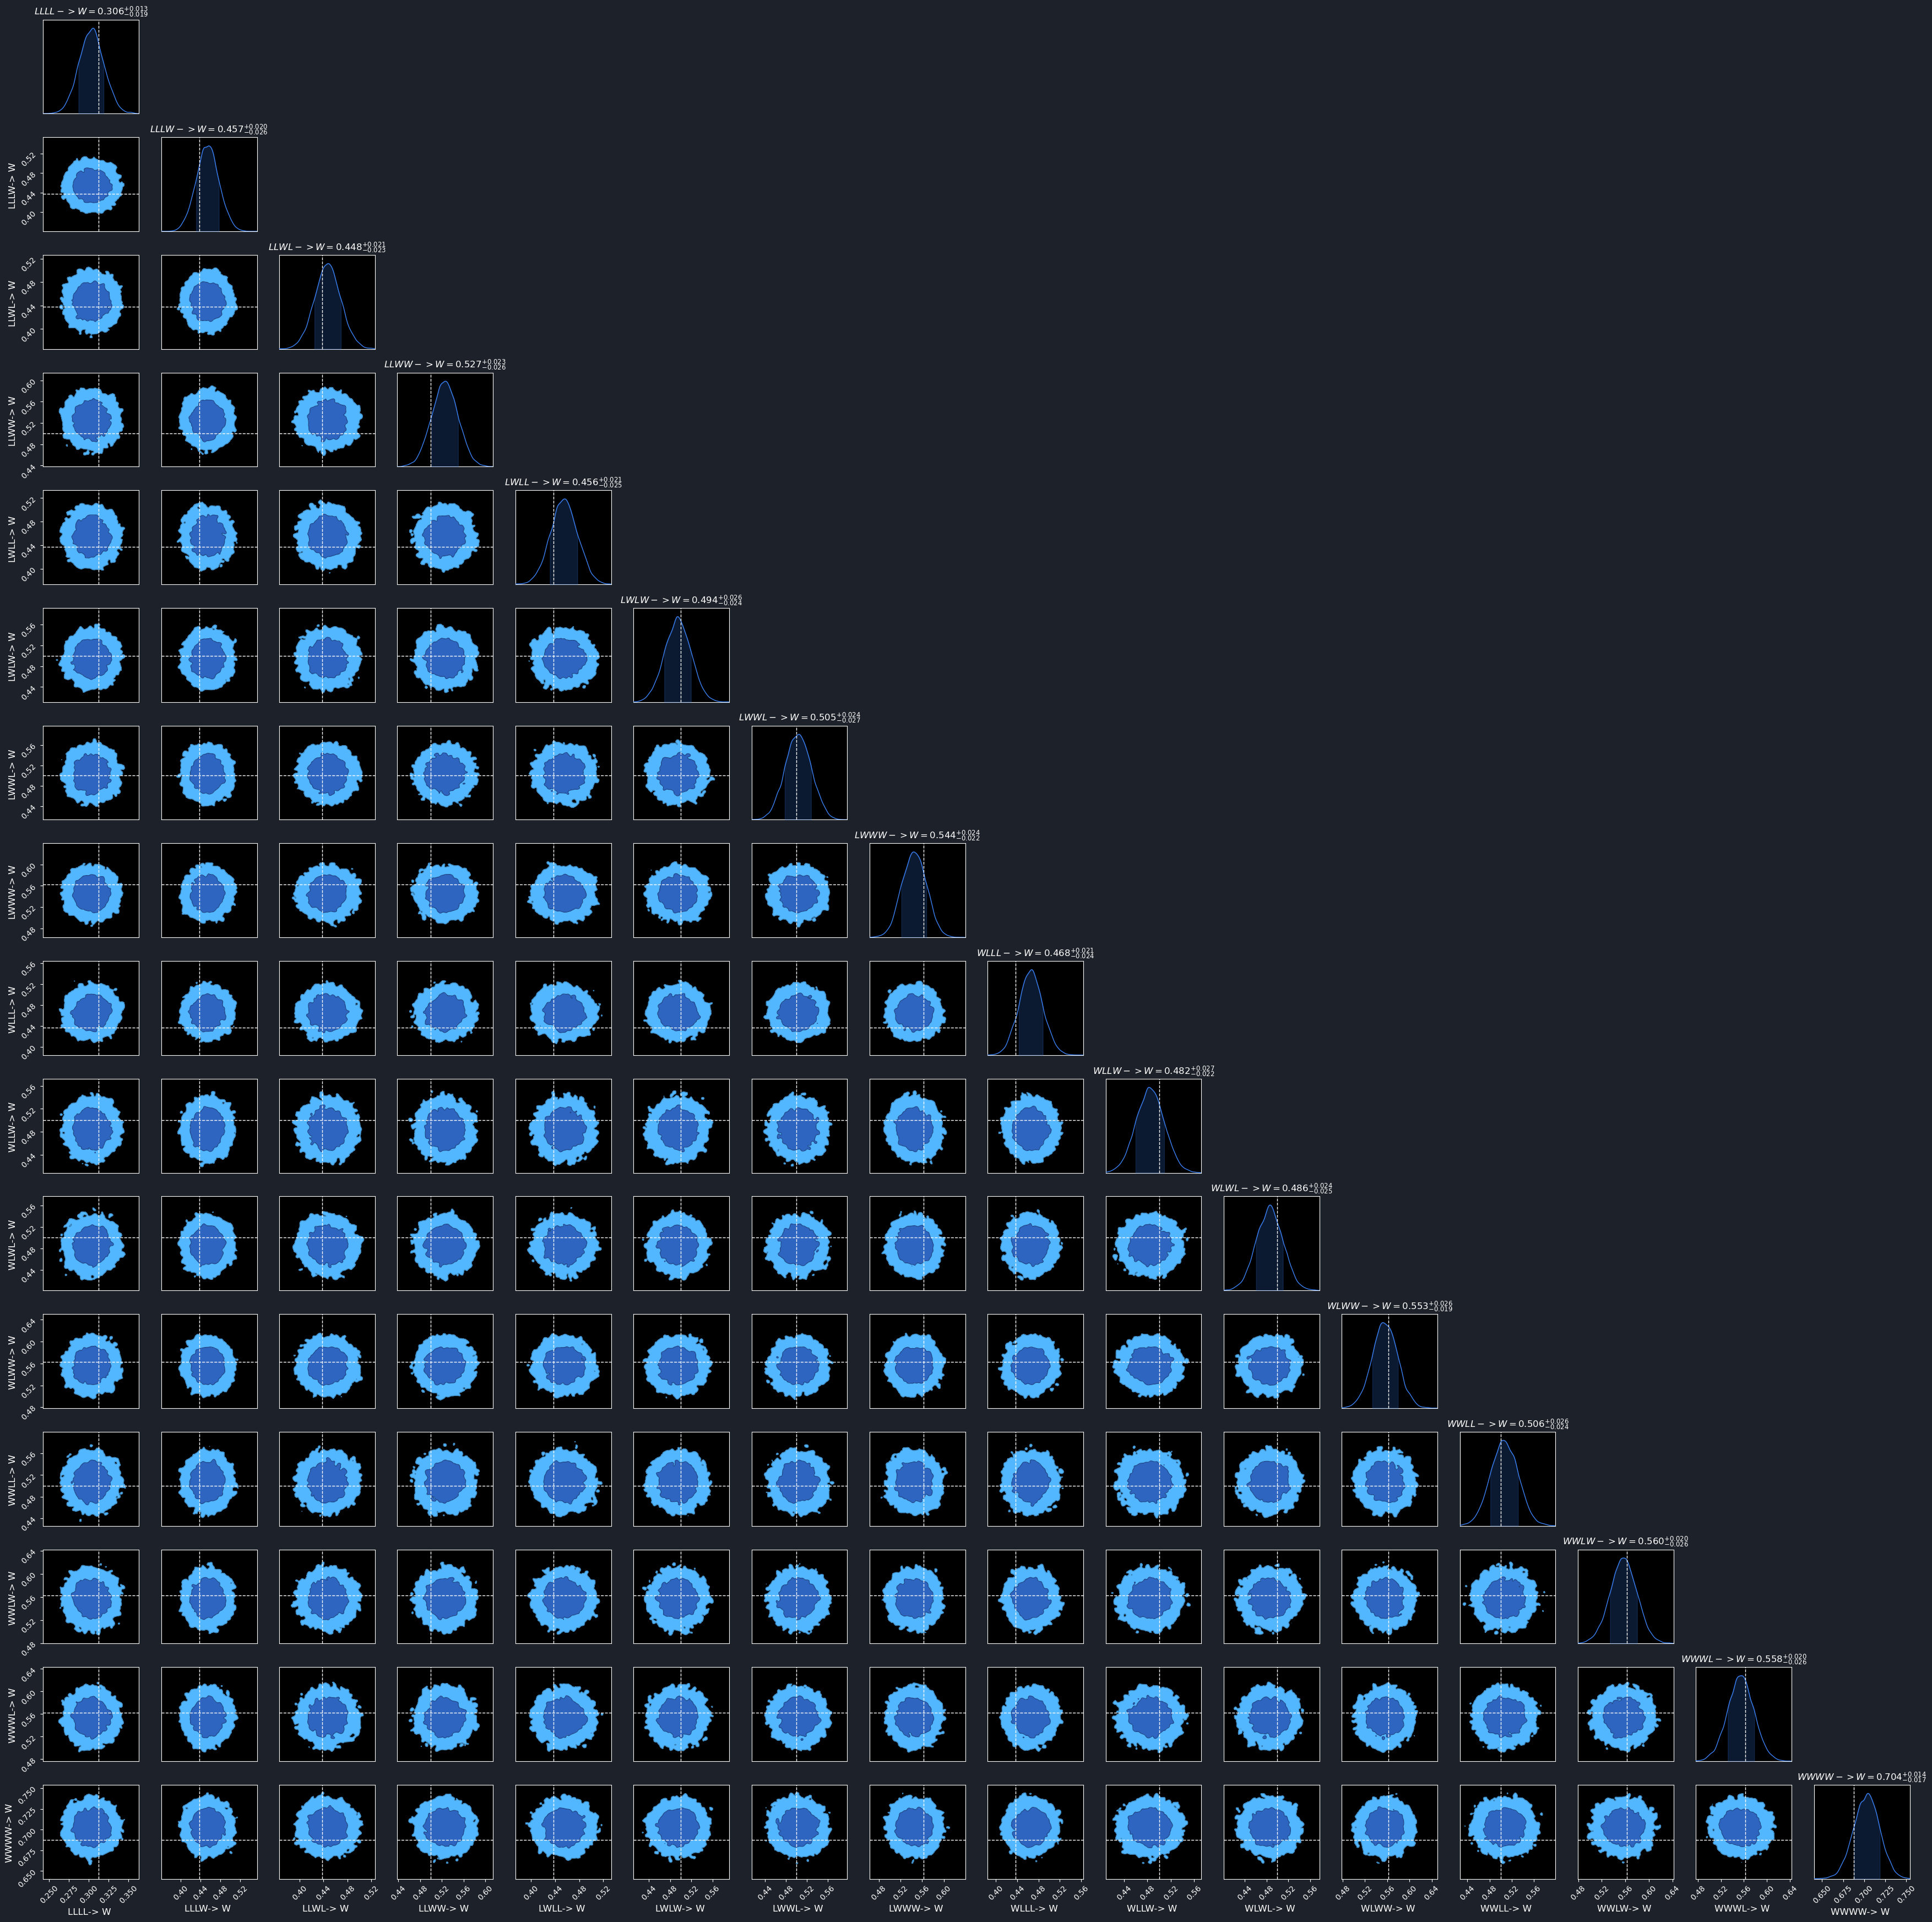

In [22]:
with plt.style.context("dark_background"):
    
    cc = ChainConsumer()
    cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
    cc.add_truth(
        Truth(location={''.join(["W" if win else "L" for win in state]) + '-> W':float(probs[i]) for i, state in enumerate(markov_util.get_states())},
              color="white"
        )
    )
    
    cc.plotter.plot()
    plt.gcf().patch.set_facecolor('#1d2129')
    plt.tight_layout()
    plt.savefig('docs/loserQ/assets/obvious_loserq_darkmode.png', bbox_inches='tight');

# Nasty LoserQ

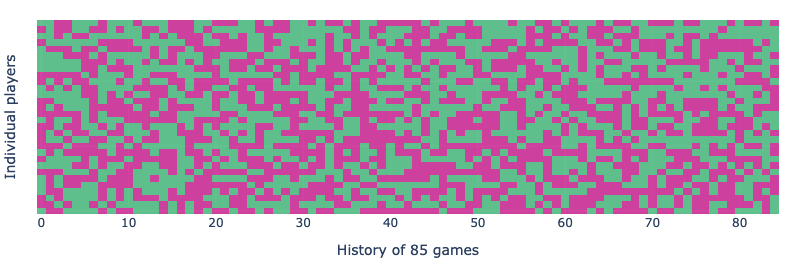

In [9]:
mock_history = generate_nasty_loser_q(number_of_players=30, number_of_games=85)
plot_history(mock_history, save_to='docs/loserQ/assets/validation_nasty.json');

In [10]:
from leaguedata.inference import fit_history_with_dmc

mock_history = generate_nasty_loser_q(number_of_players=100, number_of_games=85)
dict_of_id = fit_history_with_dmc(mock_history)
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

sample: 100%|██████████| 2000/2000 [00:11<00:00, 172.51it/s]


rank     elpd_loo      p_loo  elpd_diff        weight        se  \
4 games     0 -5885.372186  16.038508   0.000000  6.179339e-01  6.577616   
2 games     1 -5889.400684   4.156333   4.028498  1.832709e-01  3.990827   
1 games     2 -5891.318692   2.242094   5.946506  0.000000e+00  2.238271   
3 games     3 -5891.739866   8.294788   6.367680  0.000000e+00  4.740208   
0 games     4 -5892.643767   1.303287   7.271581  1.987952e-01  0.828780   
5 games     5 -5895.519557  32.411246  10.147371  0.000000e+00  7.707859   
6 games     6 -5912.161360  63.593443  26.789174  4.083400e-13  9.290571   

              dse  warning scale  
4 games  0.000000    False   log  
2 games  5.565853    False   log  
1 games  5.933768    False   log  
3 games  5.516559    False   log  
0 games  6.576612    False   log  
5 games  3.892805    False   log  
6 games  6.507514    False   log

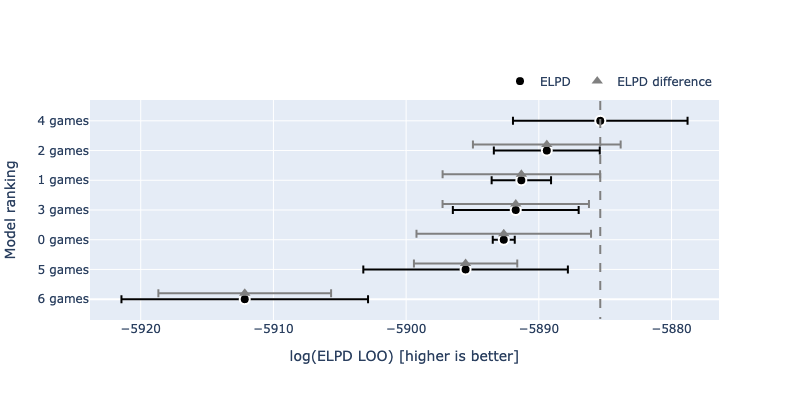

In [11]:
plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/validation_nasty_compare.json');

In [ ]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['1']
markov_util = DTMCModel(1)
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""

In [ ]:
cc.plotter.plot_distributions();

In [ ]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4']
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util_ref.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.add_truth(Truth(location={str(state) + '-> (1)':probs_keys[sum(state)/4] for i, state in enumerate(markov_util_ref.get_states())}, line_style=":", color="red"))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""